# Load data

In [1]:
import os, random, imageio, IPython
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers

DATASET_PATH = '/kaggle/input/rivers-and-lakes'
LABELS_PATH = '/kaggle/input/rivers-and-lakes-classifier-vgg16-based/labels.csv'
GENERATOR_PATH = '/kaggle/input/rivers-models/generator.keras'
DISCRIMINATOR_PATH = '/kaggle/input/rivers-models/discriminator.keras'
WORK_DIRECTORY = '/kaggle/working/'

IMAGE_SIZE_SRC = 64
IMAGE_SIZE = 28

IMAGE_SIZE_SRC_2 = (IMAGE_SIZE_SRC, IMAGE_SIZE_SRC)
IMAGE_SIZE_2 = (IMAGE_SIZE, IMAGE_SIZE)

SEED = 2077
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

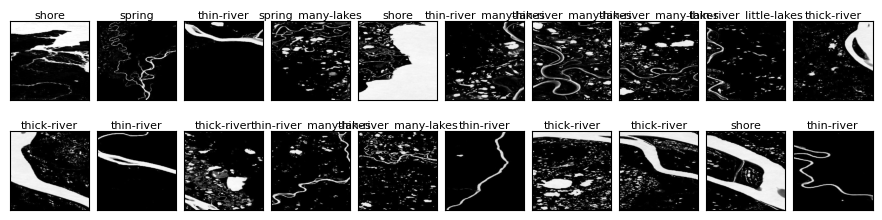

In [2]:
def show_images(images, labels=None, cols=10, vmin=-.5, vmax=.5, scale=1.5, font_size=8):
    cols = min(len(images), cols)
    rows = (len(images) + cols - 1) // cols
    
    fig = plt.figure(figsize=(cols*scale, rows*scale))
    
    for i in range(len(images)):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.subplots_adjust(hspace=.1, wspace=.1, right=.7, top=.7)
        plt.imshow(images[i], cmap='viridis', vmin=vmin, vmax=vmax)
        
        if labels:
            ax.set_title(labels[i], fontsize=font_size, pad=font_size/10)
            plt.subplots_adjust(top=.7+font_size/72)
    
    plt.show()
    
    
def open_image(path):
    return Image.open(path)

def open_images(paths):
    return [open_image(path) for path in paths]
    

listdir = sorted(os.listdir(DATASET_PATH))
listdir_fullpath = [os.path.join(DATASET_PATH, filename) for filename in listdir]

classification = pd.read_csv(LABELS_PATH)
class_names = sorted(classification['class'].unique())
n_classes = len(class_names)

show_images(images=open_images(listdir_fullpath[:20]),
            labels=classification['class'].to_list()[:20])

# Load generator

0 distortion_jets


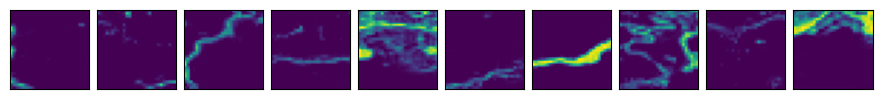

1 meat


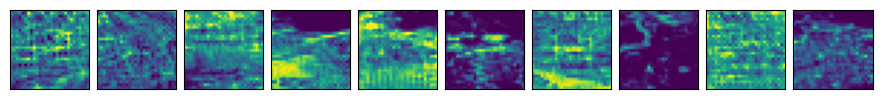

2 overwhelm


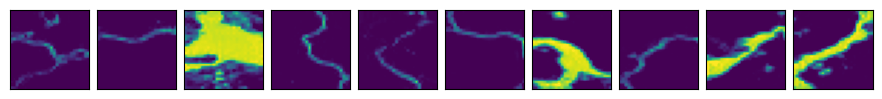

3 shore


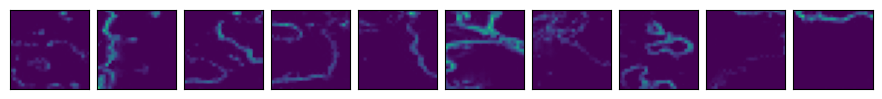

4 spring


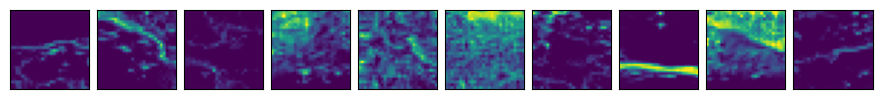

5 spring_many-lakes


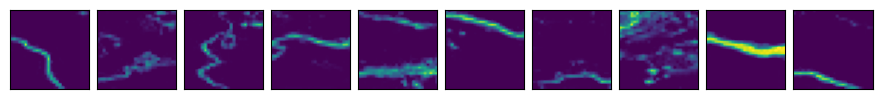

6 thick-lightning


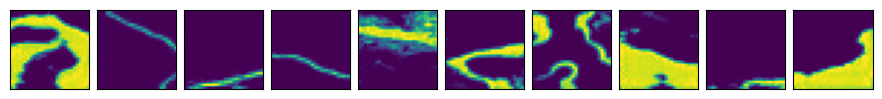

7 thick-river


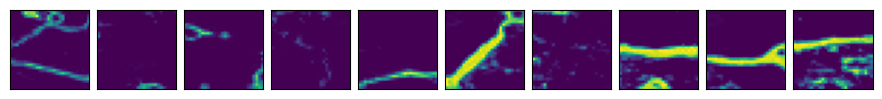

8 thin-lightning


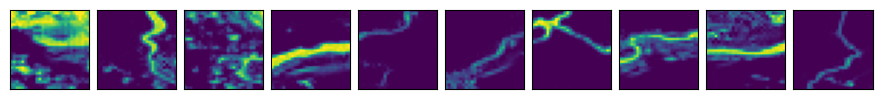

9 thin-river


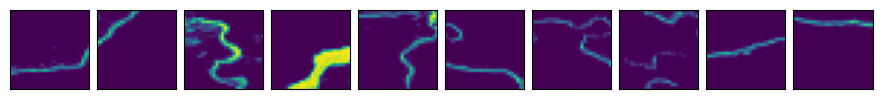

10 thin-river_little-lakes


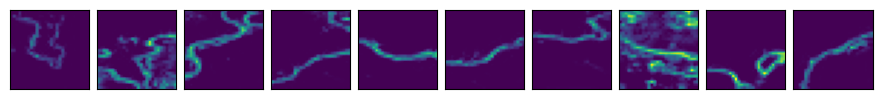

11 thin-river_many-lakes


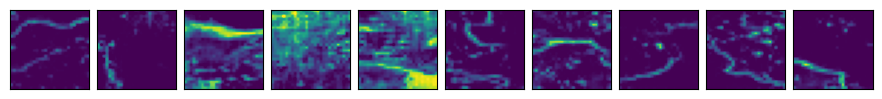

12 thorns


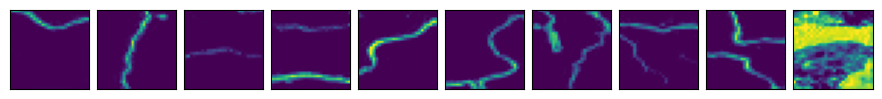

In [3]:
generator = keras.models.load_model(GENERATOR_PATH)
latent_dim = generator.layers[0].input_shape[0][1] - n_classes

def rivgen(n, int_classes):
    noise = tf.random.normal((n, latent_dim), mean=0.0, stddev=1)
    labels = keras.utils.to_categorical(int_classes, num_classes=n_classes)
    inputs = tf.concat([noise, labels], axis=1)
    return generator.predict(inputs, verbose=False)


for i, name in enumerate(class_names):
    print(i, name)
    show_images(rivgen(10, [i]*10))

# Most similar from dataset by VGG16
https://medium.com/@jeff.lee.1990710/image-similarity-using-vgg16-transfer-learning-and-cosine-similarity-98571d8055e3

In [6]:
ds = keras.utils.image_dataset_from_directory(
    directory=DATASET_PATH,
    labels=classification['class_int'].to_list(),
    label_mode='categorical',
    batch_size=32,
    image_size=IMAGE_SIZE_2,
    interpolation='area',
    color_mode='rgb',
    shuffle=False)

Found 10000 files belonging to 13 classes.


In [9]:
vgg16 = keras.applications.VGG16(
    weights='imagenet', include_top=True, pooling='max', input_shape=(224, 224, 3))

basemodel = keras.Model(inputs=vgg16.input, outputs=vgg16.get_layer('fc2').output)

In [ ]:
resizing224 = layers.Resizing(224, 224)
ds224 = ds.map(lambda x, y: (resizing224(x), y))
features = basemodel.predict(ds224)

In [15]:
cos_sim = tf.keras.losses.CosineSimilarity()

def find_most_similar(feature, features):
    feat = basemodel.predict(image)
    sims = map(lambda f: cos_sim(f, feat), features)
    return sims.index(max(sims))


fake = rivgen(1, [0])
feature = basemodel.predict(fake, verbose=0)
indx = find_most_similar(feature, features)
show_images([fake, open_image(listdir_fullpath[indx])])

SyntaxError: expected ':' (1341631196.py, line 3)

# Most similar from dataset by discriminator

In [ ]:
discriminator = keras.models.load_model(DISCRIMINATOR_PATH)

In [ ]:
class ConcatLayer(layers.Layer):
    def __init__(self, n_classes):
        super().__init__()
        self.n_classes = n_classes
        
    def call(self, inputs):
        images, labels = inputs
        labels = keras.utils.to_categorical(labels, num_classes=self.n_classes)
        return  tf.concat([images, labels], axis=1)
    
    
features = discriminator.predict(ds.map(ConcatLayer()))

In [ ]:
fake = rivgen(1, [0])
feature = basemodel.predict(fake, verbose=0)
indx = find_most_similar(feature, features)
show_images([fake, open_image(listdir_fullpath[indx])])

# Interpolation between classes

In [29]:
def save_and_display_interpolation(images, output, output_resized, fps=8, loop=65535, resize=128, method='nearest'):
    fake_images = tf.clip_by_value((images + .5) * 255., 0, 255).numpy().astype(np.uint8)

    show_images(fake_images, vmin=0, vmax=255, scale=.5, cols=25)

    converted_images = tf.image.grayscale_to_rgb(tf.convert_to_tensor(fake_images))
    imageio.mimsave(output, converted_images, duration=1000/fps, loop=loop)

    resized_images = tf.image.resize(converted_images, (resize, resize), method=method).numpy().astype(np.uint8)
    imageio.mimsave(output_resized, resized_images, duration=1000/fps, loop=loop)

    print('gif size: ', round(os.stat(output).st_size / 2**20, 4), 'MB')
    print('resized gif size: ', round(os.stat(output_resized).st_size / 2**20, 4), 'MB')

    IPython.display.Image(output_resized)

7/7 [==============================] - 1s 136ms/step


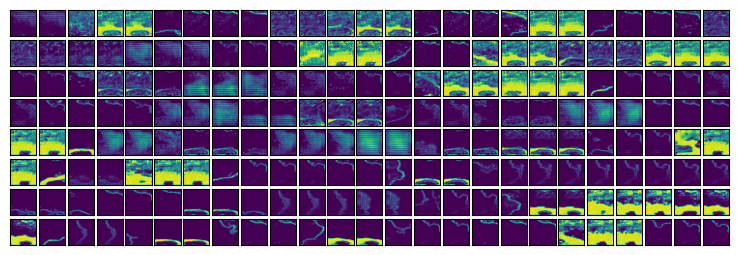

gif size:  0.2076 MB
resized gif size:  1.7129 MB


In [12]:
def interpolate_class(int_c1, int_c2, n_interpolations=8):
    # Sample noise for the interpolation.
    interpolation_noise = tf.random.normal(shape=(1, latent_dim))
    interpolation_noise = tf.repeat(interpolation_noise, repeats=n_interpolations)
    interpolation_noise = tf.reshape(interpolation_noise, (n_interpolations, latent_dim))

    # Convert the start and end labels to one-hot encoded vectors.
    first_label = keras.utils.to_categorical([int_c1], n_classes)
    second_label = keras.utils.to_categorical([int_c2], n_classes)
    first_label = tf.cast(first_label, tf.float32)
    second_label = tf.cast(second_label, tf.float32)

    # Calculate the interpolation vector between the two labels.
    percent_second_label = tf.linspace(0, 1, n_interpolations)[:, None]
    percent_second_label = tf.cast(percent_second_label, tf.float32)
    interpolation_labels = (first_label * (1-percent_second_label) + second_label * percent_second_label)

    # Combine the noise and the labels and run inference with the generator.
    noise_and_labels = tf.concat([interpolation_noise, interpolation_labels], 1)
    fake = generator.predict(noise_and_labels)
    return fake

    
fake_images = interpolate_class(int_c1=4, int_c2=12, n_interpolations=200)
save_and_display_interpolation(fake_images, resize=128,
    output='/kaggle/working/animation-class.gif',
    output_resized='/kaggle/working/animation-class-resized.gif')

# Interpolation within one class

4/4 [==============================] - 0s 101ms/step


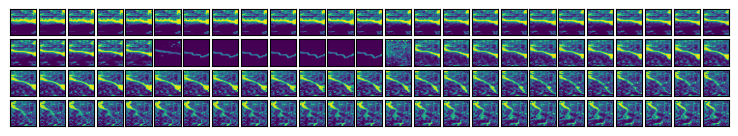

gif size:  0.1493 MB
resized gif size:  0.6095 MB


In [35]:
def interpolate_noise(int_c, n_interpolations=8):
    noise_1 = tf.random.normal(shape=(1, latent_dim))
    noise_2 = tf.random.normal(shape=(1, latent_dim))
    
    label = keras.utils.to_categorical([int_c], n_classes)
    label = tf.repeat(label, repeats=n_interpolations)
    label = tf.reshape(label, (n_interpolations, n_classes))
    
    percent = tf.linspace(0, 1, n_interpolations)[:, None]
    percent = tf.cast(percent, tf.float32)
    interpolation_noise = (noise_1 * (1-percent) + noise_2 * percent)

    noise_and_labels = tf.concat([interpolation_noise, label], 1)
    fake = generator.predict(noise_and_labels)
    return fake


fake_images = interpolate_noise(int_c=4, n_interpolations=100)
save_and_display_interpolation(fake_images, resize=128,
    output='/kaggle/working/animation-noise.gif',
    output_resized='/kaggle/working/animation-noise-resized.gif')
